## CONUS404 Data on the Planetary Computer

The [CONUS404 Dataset](https://doi.org/10.1175/BAMS-D-21-0326.1), as available from the [NCAR Research Data Archive](https://rda.ucar.edu/datasets/d559000/) has been converted to the Analysis Ready, Cloud Optimized format Zarr on Planetary Computer. Note that the data is also available via [USGS](https://doi.org/10.5066/P9PHPK4F).

Here we will show:
* How to access the data
* Plots of some useful fields in the dataset
* How to convert data from the Weather Research and Forecasting (WRF) model's native vertical level to pressure levels

### Accessing the dataset

The dataset consists of a single zarr store.

In [1]:
import planetary_computer
import xarray
import pystac_client

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

c = catalog.get_collection("conus404")
asset = c.assets["zarr-abfs"]
ds = xarray.open_zarr(
    asset.href,
    storage_options=asset.extra_fields["xarray:storage_options"],
    **asset.extra_fields["xarray:open_kwargs"],
)
ds

<xarray.Dataset> Size: 2PB
Dimensions:         (time: 376944, south_north: 1015, west_east: 1367,
                     bottom_top: 50, soil_layers_stag: 4, snow_layers_stag: 3,
                     west_east_stag: 1368, south_north_stag: 1016,
                     bottom_top_stag: 51, snso_layers_stag: 7)
Coordinates:
    lat             (south_north, west_east) float32 6MB ...
    lat_u           (south_north, west_east_stag) float32 6MB ...
    lat_v           (south_north_stag, west_east) float32 6MB ...
    lon             (south_north, west_east) float32 6MB ...
    lon_u           (south_north, west_east_stag) float32 6MB ...
    lon_v           (south_north_stag, west_east) float32 6MB ...
  * time            (time) datetime64[ns] 3MB 1979-10-01 ... 2022-09-30T23:00:00
Dimensions without coordinates: south_north, west_east, bottom_top,
                                soil_layers_stag, snow_layers_stag,
                                west_east_stag, south_north_stag,
                                bottom_top_stag, snso_layers_stag
Data variables: (12/200)
    ACDEWC          (time, south_north, west_east) float32 2TB ...
    ACDRIPR         (time, south_north, west_east) float32 2TB ...
    ACDRIPS         (time, south_north, west_east) float32 2TB ...
    ACECAN          (time, south_north, west_east) float32 2TB ...
    ACEDIR          (time, south_north, west_east) float32 2TB ...
    ACETLSM         (time, south_north, west_east) float32 2TB ...
    ...              ...
    Z               (time, bottom_top_stag, south_north, west_east) float32 107TB ...
    ZSNSO           (time, snso_layers_stag, south_north, west_east) float32 15TB ...
    ZWT             (time, south_north, west_east) float32 2TB ...
    totalIce        (time, south_north, west_east) float32 2TB ...
    totalLiq        (time, south_north, west_east) float32 2TB ...
    totalVap        (time, south_north, west_east) float32 2TB ...
Attributes:
    abstract:         CONUS404 is a unique, high-resolution hydro-climate dat...
    acknowledgement:  In addition to the RDA dataset citation, authors are re...
    description:      This is a replication of the CONUS404 dataset from the ...
    license:          This work is licensed under a Creative Commons Attribut...

As noted in the metadata, the dataset consists of a 40 year WRF simulation over the Contiguous United States (CONUS) at 4 km horizontal resolution, and at hourly temporal frequency.

### Surface Temperature

First we show 2m temperature as:
* a map at a randomly chosen date,
* and as a time series at a random point in space over the final month of the simulation

Note that the data are chunked as 2D slices (i.e., each data chunk consists of all latitude and longitude points for a single vertical level and timestamp).
Therefore, it will take some time to process each individual chunk to produce the timeseries, whereas the spatial map at a single point in time is accessed much more quickly.

In [4]:
import matplotlib.pyplot as plt

In [5]:
%%time
temperature_map = ds["T2"].sel(time="2022-09-01T00").compute()

CPU times: user 812 ms, sys: 173 ms, total: 985 ms
Wall time: 2.06 s


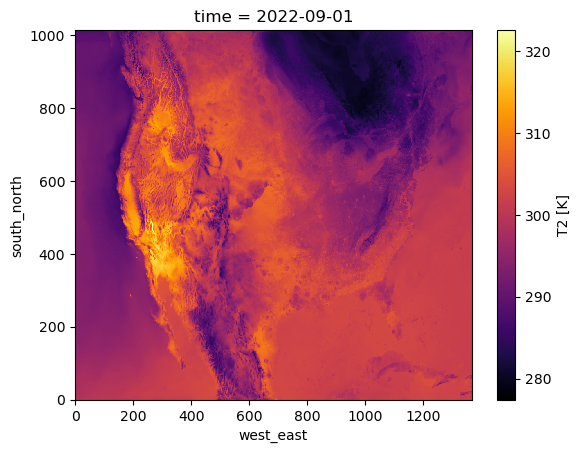

In [6]:
temperature_map.plot(cmap="inferno")

In [7]:
%%time
temperature_timeseries = (
    ds["T2"]
    .sel(
        time="2022-09",
    )
    .isel(
        west_east=100,
        south_north=100,
    )
    .compute()
);

CPU times: user 19.3 s, sys: 7.6 s, total: 26.9 s
Wall time: 49.9 s


Text(0, 0.5, '2m Temperature [$^\\circ$C]')

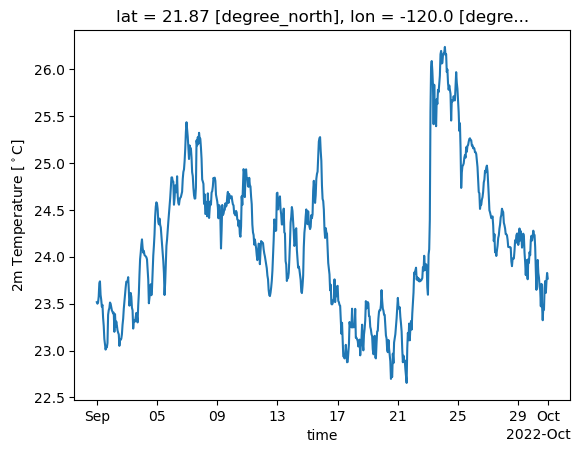

In [8]:
(temperature_timeseries - 273.15).plot()
plt.gca().set_ylabel("2m Temperature [$^\\circ$C]")

### Precipitation

Here we will show precipitation accumulated over a randomly chosen day.
Here cartopy is used to create an Orthographic projection, and the spatial coordinates are used for plotting, rather than the logical indices as shown above.
This may be useful to reduce visual distortions. 

In [9]:
import cartopy.crs as ccrs

In [10]:
def orthoplot(xda, **kwargs):
    fig, ax = plt.subplots(
        figsize=(9, 6), subplot_kw={"projection": ccrs.Orthographic(-100, 35)}
    )
    p = ax.pcolormesh(
        xda["lon"], xda["lat"], xda, transform=ccrs.PlateCarree(), **kwargs
    )
    ax.coastlines()
    return fig, ax, p

In [11]:
date = "2022-08-06"
total_precip = (
    ds["PREC_ACC_NC"]
    .sel(
        time=date,
    )
    .sum("time")
    .load()
)

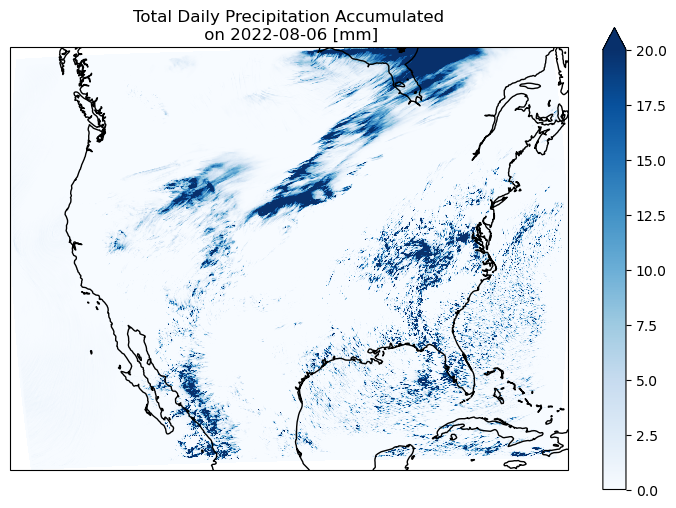

In [12]:
fig, ax, p = orthoplot(
    total_precip,
    cmap="Blues",
    vmax=20,
)
ax.set(title=f"Total Daily Precipitation Accumulated\n on {date} [mm]")
plt.colorbar(p, ax=ax, extend="max")

### Temperature at 500 hPa

The data is provided on the WRF model's native vertical coordinate, so we will show how to interpolate any 3D field to a given pressure level.

In [14]:
import numpy as np


def compute_coefficients(pstar: float, pressure: xarray.DataArray) -> xarray.Dataset:
    """Compute the coefficients needed to interpolate from native vertical grid to a
    given pressure level

    Note:
        This is the same operation used by ufs2arco for the FV3 model, see example usage
        here:
        https://ufs2arco.readthedocs.io/en/latest/example_pressure_interpolation.html

    Args:
        pstar (float): pressure level to interpolate to
        pressure (xarray.DataArray): the pressure field on the native vertical coordinates
        (must be in same units as pstar

    Returns:
        cds (xarray.Dataset): with coefficients needed for interpolation
    """
    dlev = pstar - pressure
    dloglev = np.log(pstar) - np.log(pressure)

    # get coefficients representing pressure distance left and right of pstar
    is_left = dlev == dlev.where(dlev >= 0).min("bottom_top")
    is_right = dlev == dlev.where(dlev <= 0).max("bottom_top")

    p_left = dloglev.where(is_left).sum("bottom_top")
    p_right = -dloglev.where(is_right).sum("bottom_top")

    denominator = p_left + p_right
    denominator = denominator.where(denominator > 1e-6, 1e-6)
    factor = p_left / denominator
    return xarray.Dataset(
        {
            "is_left": is_left,
            "is_right": is_right,
            "p_left": p_left,
            "p_right": p_right,
            "denominator": denominator,
            "factor": factor,
        }
    )

In [15]:
def interp2pressure(xda, cds):
    """Interpolate xda to pressure level used to compute coefficients in ``cds``

    Note:
        We do not represent values with pressure higher than the pressure at the
        surface, these are represented with NaNs.
        Again, this mirrors the code in ufs2arco
        https://github.com/NOAA-PSL/ufs2arco/blob/main/ufs2arco/layers2pressure.py

    Args:
        xda (xarray.DataArray): with the field to be interpolated
        cds (xarray.Dataset): with the coefficients computed by compute_coefficients

    Returns:
        xda_at_pstar (xarray.DataArray): original field interpolated to desired
        pressure level
    """
    xda_left = xda.where(cds["is_left"]).sum("bottom_top")
    xda_right = xda.where(cds["is_right"]).sum("bottom_top")

    result = xda_left + (xda_right - xda_left) * cds["factor"]

    mask = (cds["is_right"].sum("bottom_top") > 0) & (
        cds["is_left"].sum("bottom_top") > 0
    )
    return result.where(mask)

In [16]:
cds = compute_coefficients(
    pstar=500 * 100,  # 500 hPa -> 50,000 Pa, same units as ds.P
    pressure=ds["P"].isel(time=0).load(),
)

In [17]:
# Note this should be at the same timestamp as the pressure used to compute coefficients
t500 = interp2pressure(
    ds.TK.isel(time=0).load(),
    cds,
)

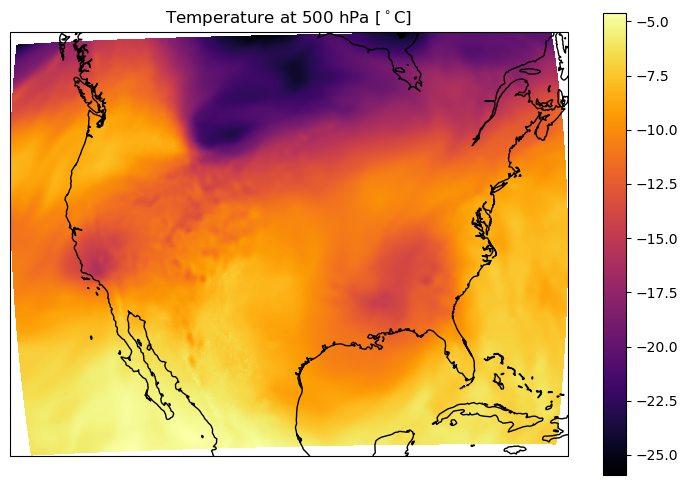

In [18]:
fig, ax, p = orthoplot(
    t500 - 273.15,
    cmap="inferno",
)
ax.set(title=r"Temperature at 500 hPa [$^\circ$C]")
plt.colorbar(p, ax=ax)